### All Libraries Needed Through the Tasks

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch import optim
#from torchvision import models
from torch.autograd import Variable
import wget


###  Definition of Import  File Function 

In [36]:
def download(fid, fn):
    durl = 'https://drive.google.com/' + 'open?id=' + fid
    print('downloading from', durl)
    wget.download(durl, fn)
    

### Common Parameters Through the Tasks

In [17]:
num_epochs = 20;
batch_size=32

### Load Data

In [18]:
#transforms.ToTensor() converts our PILImage to a tensor of shape (C x H x W) in the range [0,1]
datapath='F_MNIST_data/';
#load train data
trainset = dsets.FashionMNIST(root=datapath, train = True, transform=transforms.ToTensor(), download=True)
trainloader = DataLoader(trainset, shuffle=True, batch_size=batch_size)
#load test data
testset = dsets.FashionMNIST(root=datapath, train = False, transform=transforms.ToTensor(), download = True)
testloader = DataLoader(testset, shuffle=False, batch_size=batch_size)


## Task1

### CNN Model Definition

In [48]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        #no paddings
        #input 28x28
        #output size= (input - filter + 2*padding)/stride +1
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2)
        #13x13
       
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2)
        #6x6
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2)
        #2x2    
        self.fc1 = nn.Linear(2*2*128, 256)
        self.fc2 = nn.Linear(256, 10)
    
    def forward(self,x):
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        return out
    

### Initialize  CNN Model

In [5]:
model =CNN()

### Training CNN Model

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_acc, test_acc=[],[]

for epoch in range(num_epochs):
    train_loss = 0
    test_loss = 0
    train_accuracy = 0
    test_accuracy = 0
    for images, labels in trainloader:
        
        out = model(images)
        loss = criterion(out, labels)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        train_loss += loss.item()
        predicted = torch.argmax(out, dim=1)
        correct = (predicted == labels).sum().item()
        train_accuracy += correct/labels.size(0)
    train_acc.append(train_accuracy/len(trainloader))
    
    with torch.no_grad():
        model.eval()
        for images, labels in testloader:
            out = model(images)
            loss = criterion(out, labels)
            test_loss += loss.item()
            predicted = torch.argmax(out, dim=1)
            correct = (predicted == labels).sum().item()
            test_accuracy += correct/labels.size(0)
    test_acc.append(test_accuracy/len(testloader))
    
    model.train()  
    
    if(epoch%5==0 or epoch==19):
        print('Epoch: {}/{}, TrainLoss: {:.3f},  TestLoss: {:.3f}, TrainAccuracy: {:.3f},TestAccuracy: {:.3f}'
              .format(epoch , num_epochs, train_loss/len(trainloader), test_loss/ len(testloader),
                     train_accuracy /len(trainloader), test_accuracy / len(testloader)))
          
torch.save(model.state_dict(), "CNN_Model.pth")  
              

Epoch: 0/20, TrainLoss: 0.545,  TestLoss: 0.476, TrainAccuracy: 0.797,TestAccuracy: 0.816
Epoch: 5/20, TrainLoss: 0.224,  TestLoss: 0.308, TrainAccuracy: 0.915,TestAccuracy: 0.894
Epoch: 10/20, TrainLoss: 0.125,  TestLoss: 0.376, TrainAccuracy: 0.952,TestAccuracy: 0.896
Epoch: 15/20, TrainLoss: 0.074,  TestLoss: 0.516, TrainAccuracy: 0.972,TestAccuracy: 0.891
Epoch: 19/20, TrainLoss: 0.054,  TestLoss: 0.639, TrainAccuracy: 0.980,TestAccuracy: 0.892


### CNN Model Google Drive Link

In [49]:
#https://drive.google.com/open?id=1F456ZrzQBwTFFtEvlDtA5QObLWKPrGl4
fid = '1F456ZrzQBwTFFtEvlDtA5QObLWKPrGl4'
download(fid, 'CNN_model.pth')
model =CNN()
model.load_state_dict(torch.load("CNN_model.pth"))

downloading from https://drive.google.com/uc?export=download&id=1F456ZrzQBwTFFtEvlDtA5QObLWKPrGl4


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

### Plots and Analysis

Text(0,0.5,'Accuracy')

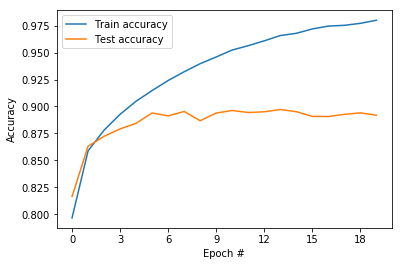

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import MaxNLocator

ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.plot(train_acc,label = "Train accuracy")
plt.plot(test_acc, label = "Test accuracy")
plt.legend()
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")

## Task2

### VAE Model Definition

In [33]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Encoder
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2)
        #13x13
       
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2)
        #6x6
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2)
        #2x2    
        self.fc1 = nn.Linear(2*2*128, 256)
        
        self.fc21 = nn.Linear(256, 256) #mean layer
        self.fc22 = nn.Linear(256, 256) #variance layer
        
        # Sampling vector
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 2 * 2 * 128)
        
        
      # Decoder
        self.conv5 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2,output_padding=1)
        self.conv6 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2)
        self.conv7 = nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2,output_padding=1)
    
    def forward(self,x):
        #encode
        conv1 = F.relu(self.conv1(x))
        conv2 = F.relu(self.conv2(conv1))
        conv3 = F.relu(self.conv3(conv2))
        conv3 = conv3.view(conv3.size(0),-1)
        
        #Calculate latent vectors
        fc1 = F.relu(self.fc1(conv3))
        mu = self.fc21(fc1)
        logvar = self.fc22(fc1)
       
        # Sample from latent vectors
        std = logvar.mul(0.5).exp_()
        eps = Variable(std.data.new(std.size()).normal_())
        z = eps.mul(std).add_(mu)
        
        #decode
        fc3 = F.relu(self.fc3(z))
        fc4 = F.relu(self.fc4(fc3))
        fc4 = fc4.view(-1,128,2,2)
        conv5 = F.relu(self.conv5(fc4))
        conv6 = F.relu(self.conv6(conv5))
        out = self.conv7(conv6).view(-1, 1, 28, 28)
        return out, mu ,logvar


### Loss function

In [9]:
class Loss(nn.Module):
    def __init__(self):
        super(Loss, self).__init__()
        self.bn_loss = nn.BCEWithLogitsLoss()
    def forward(self, recon_x, x, mu, logvar):
        BN = self.bn_loss(recon_x, x)
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2)-logvar.exp())
        #normalize
        KLD /= batch_size * 784
        return BN + KLD


### Initiolize VAE Model

In [10]:
model =VAE()

### Training VAE Model

In [11]:
#train model

criterion = Loss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

for epoch in range(num_epochs):
    train_loss = 0
    for images, labels in trainloader:
        
        op,mu,logvar = model(images)
        loss=criterion(op, images, mu, logvar)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() 
        train_loss += loss
            
    if(epoch%5==0 or epoch==19):
        print('Epoch: {}/{}, TrainLoss: {:.3f}'
              .format(epoch, num_epochs,train_loss/len(trainloader)))
    
                
torch.save(model.state_dict(), "VAE_model.pth")                

Epoch: 0/20, TrainLoss: 0.432
Epoch: 5/20, TrainLoss: 0.384
Epoch: 10/20, TrainLoss: 0.382
Epoch: 15/20, TrainLoss: 0.381
Epoch: 19/20, TrainLoss: 0.381


### VAE Model Google Drive Link

In [50]:
#https://drive.google.com/open?id=1XQ96BOUNLVNB532yU7a7eRZSXWrzlZGv
fid = '1XQ96BOUNLVNB532yU7a7eRZSXWrzlZGv'
download(fid,'VAE_model.pth')
model =VAE()
model.load_state_dict(torch.load("VAE_model.pth"))

downloading from https://drive.google.com/uc?export=download&id=1XQ96BOUNLVNB532yU7a7eRZSXWrzlZGv


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

### Plots and Analysis

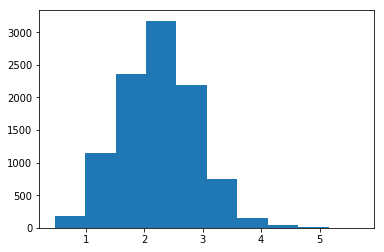

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline
model =VAE()
model.load_state_dict(torch.load("VAE_model.pth"))

with torch.no_grad():
    model.eval()

    x=[]
    for images, _ in testloader:
        _,mu,_ = model(images)
        norm2 = torch.norm(mu, p=2, dim=1)
        x.extend(norm2)
    plt.hist(x)


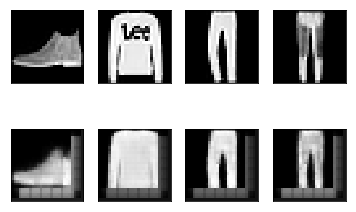

In [24]:
with torch.no_grad():
    model.eval()
    for images, _ in testloader:
        for i in range(4):
    # display original
            ax = plt.subplot(2, 4, i + 1)
            plt.imshow(images[i].reshape(28, 28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    # display reconstruction
            recon_img,_,_ = model(images)
            y_prob = torch.sigmoid(recon_img)
            ax = plt.subplot(2, 4, i + 1 + 4)
            plt.imshow(y_prob[i].reshape(28, 28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        break   
        plt.show()
    

## Task3

### Joint Model Definition

In [25]:
class JOINT(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Encoder
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2)
        #13x13
       
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2)
        #6x6
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2)
        #2x2    
        self.fc1 = nn.Linear(2*2*128, 256)
        
        self.fc21 = nn.Linear(256, 256) #mean layer
        self.fc22 = nn.Linear(256, 256) #variance layer
        
        #pass mean to softmax layer
        self.soft = nn.Linear(256, 10)
        
        
        # Sampling vector
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 2 * 2 * 128)
        
        
      # Decoder
        self.conv5 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2,output_padding=1)
        self.conv6 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2)
        self.conv7 = nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2,output_padding=1)
    
    def forward(self,x):
        #encode
        conv1 = F.relu(self.conv1(x))
        conv2 = F.relu(self.conv2(conv1))
        conv3 = F.relu(self.conv3(conv2))
        conv3 = conv3.view(conv3.size(0),-1)
        
        
        #Calculate latent vectors
        fc1 = F.relu(self.fc1(conv3))
        mu = self.fc21(fc1)
        logvar = self.fc22(fc1)
        
        #softlayer
        softlayer = self.soft(mu)
       
        # Sample from latent vectors
        std = logvar.mul(0.5).exp_()
        eps = Variable(std.data.new(std.size()).normal_())
        z = eps.mul(std).add_(mu)
        
        #decode
        fc3 = F.relu(self.fc3(z))
        fc4 = F.relu(self.fc4(fc3))
        fc4 = fc4.view(-1,128,2,2)
        conv5 = F.relu(self.conv5(fc4))
        conv6 = F.relu(self.conv6(conv5))
        out = self.conv7(conv6).view(-1, 1, 28, 28)
        
        return out, mu ,logvar, softlayer



### Loss Function

In [26]:
class Loss(nn.Module):
    def __init__(self):
        super(Loss, self).__init__()
        self.entropy_loss =  nn.CrossEntropyLoss()
        self.bn_loss = nn.BCEWithLogitsLoss()
    def forward(self, recon_x, x, mu, logvar,softlayer,label):
        EN = self.entropy_loss(softlayer, label)
        BN = self.bn_loss(recon_x, x)
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2)-logvar.exp())
        #normalize
        KLD /= batch_size * 784
        return BN + KLD+EN

Initiolization Joint Model

In [27]:
model =JOINT()


### Training Joint Model

In [28]:
criterion = Loss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

train_acc, test_acc=[],[]

for epoch in range(num_epochs):
    train_loss = 0
    test_loss = 0
    train_accuracy = 0
    test_accuracy = 0
    for images, labels in trainloader:
        
        op,mu,logvar,softlayer = model(images)
        loss=criterion(op, images, mu, logvar,softlayer,labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss
        predicted = torch.argmax(softlayer, dim=1)
        correct = (predicted == labels).sum().item()
        train_accuracy += correct/labels.size(0)
    
    train_acc.append(train_accuracy/len(trainloader))
    
    with torch.no_grad():
        model.eval()
        for images, labels in testloader:
            op,mu,logvar,softlayer = model(images)
            loss=criterion(op, images, mu, logvar,softlayer,labels)
            test_loss += loss
            predicted = torch.argmax(softlayer, dim=1)
            
            correct = (predicted == labels).sum().item()
            test_accuracy += correct/labels.size(0)
    test_acc.append(test_accuracy/len(testloader))
    
    model.train()        
            
    if(epoch%5==0 or epoch==19):
        print('Epoch: {}/{}, TrainLoss: {:.3f},  TestLoss: {:.3f}, TrainAccuracy: {:.3f},TestAccuracy: {:.3f}'
              .format(epoch + 1, num_epochs, train_loss/len(trainloader), test_loss/ len(testloader),
                     train_accuracy /len(trainloader), test_accuracy / len(testloader)))
    
        
        
torch.save(model.state_dict(), "jointmodel.pth")  
              

Epoch: 1/20, TrainLoss: 0.986,  TestLoss: 0.842, TrainAccuracy: 0.805,TestAccuracy: 0.846
Epoch: 6/20, TrainLoss: 0.614,  TestLoss: 0.732, TrainAccuracy: 0.922,TestAccuracy: 0.890
Epoch: 11/20, TrainLoss: 0.521,  TestLoss: 0.778, TrainAccuracy: 0.956,TestAccuracy: 0.889
Epoch: 16/20, TrainLoss: 0.475,  TestLoss: 0.863, TrainAccuracy: 0.972,TestAccuracy: 0.889
Epoch: 20/20, TrainLoss: 0.456,  TestLoss: 0.939, TrainAccuracy: 0.978,TestAccuracy: 0.888


### Joint Model Google Drive Link 

In [40]:
#https://drive.google.com/open?id=1WmelDJlVmtUeAEE8IwbD3uR-B0QSHynL
fid = '1WmelDJlVmtUeAEE8IwbD3uR-B0QSHynL'
download(fid, 'joint_model.pth')
model =JOINT()
model.load_state_dict(torch.load("joint_model.pth"))

downloading from https://drive.google.com/uc?export=download&id=1WmelDJlVmtUeAEE8IwbD3uR-B0QSHynL


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

### Plots and Analysis

Text(0,0.5,'Accuracy')

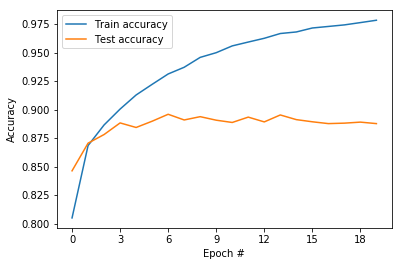

In [41]:
 import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import MaxNLocator

ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.plot(train_acc,label = "Train accuracy")
plt.plot(test_acc, label = "Test accuracy")
plt.legend()
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")

### Training Transfer Model

In [42]:

model =VAE()
model.load_state_dict(torch.load("VAE_model.pth"))

class Transfer(nn.Module):
    def __init__(self):
        super().__init__()       
        self.conv1 = model.conv1
        self.conv2 = model.conv2
        self.conv3 = model.conv3  
        self.fc1 = model.fc1
        self.mean = model.fc21
        
        #discard decoder and add new layer

        self.softlayer = nn.Linear(256, 10)
                
    def forward(self, x):
        conv1 = F.relu(self.conv1(x))
        conv2 = F.relu(self.conv2(conv1))
        conv3 = F.relu(self.conv3(conv2))
        conv3 = conv3.view(conv3.size(0),-1)
        
        fc1 = F.relu(self.fc1(conv3))
        mu = self.mean(fc1)
        out = self.softlayer(mu)
        return out
            

### Initiolization Transfer Model

In [43]:
model_tranfer = Transfer()

### Training Transfer Model

In [44]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_tranfer.parameters(), lr=0.001)
#train model
train_acc, test_acc=[],[]

for epoch in range(num_epochs):
    train_loss = 0
    test_loss = 0
    train_accuracy = 0
    test_accuracy = 0
    for images, labels in trainloader:
        
        op = model_tranfer(images)
        loss = criterion(op, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        predicted = torch.argmax(op, dim=1)
        correct = (predicted == labels).sum().item()
        train_accuracy += correct/labels.size(0)
    
    train_acc.append(train_accuracy/len(trainloader))
    
    with torch.no_grad():
        model_tranfer.eval()
        for images, labels in testloader:
            op = model_tranfer(images)
            loss = criterion(op, labels)
            test_loss += loss.item()
            predicted = torch.argmax(op, dim=1)
            correct = (predicted == labels).sum().item()
            test_accuracy += correct/labels.size(0)
    test_acc.append(test_accuracy/len(testloader))
    
    model_tranfer.train()        
            
    if(epoch%5==0 or epoch==19):
        print('Epoch: {}/{}, TrainLoss: {:.3f},  TestLoss: {:.3f}, TrainAccuracy: {:.3f},TestAccuracy: {:.3f}'
              .format(epoch , num_epochs, train_loss/len(trainloader), test_loss/ len(testloader),
                     train_accuracy /len(trainloader), test_accuracy / len(testloader)))
    
        
        
torch.save(model_tranfer.state_dict(), "transfermodel.pth") 

Epoch: 0/20, TrainLoss: 0.585,  TestLoss: 0.529, TrainAccuracy: 0.782,TestAccuracy: 0.794
Epoch: 5/20, TrainLoss: 0.392,  TestLoss: 0.439, TrainAccuracy: 0.851,TestAccuracy: 0.834
Epoch: 10/20, TrainLoss: 0.358,  TestLoss: 0.412, TrainAccuracy: 0.864,TestAccuracy: 0.844
Epoch: 15/20, TrainLoss: 0.337,  TestLoss: 0.414, TrainAccuracy: 0.870,TestAccuracy: 0.851
Epoch: 19/20, TrainLoss: 0.325,  TestLoss: 0.418, TrainAccuracy: 0.875,TestAccuracy: 0.850


### Transfer Model Goolge Drive Link

In [46]:
#https://drive.google.com/open?id=1nAnWs5g8Z31T_7TkV2x2J_Om0yxsqqEO
fid = '1nAnWs5g8Z31T_7TkV2x2J_Om0yxsqqEO'
download(fid, 'transfer_model.pth')
model =Transfer()
model.load_state_dict(torch.load("transfer_model.pth"))

downloading from https://drive.google.com/uc?export=download&id=1nAnWs5g8Z31T_7TkV2x2J_Om0yxsqqEO


IncompatibleKeys(missing_keys=[], unexpected_keys=[])